<a href="https://colab.research.google.com/github/giuliasaccomano/giuliasaccomano/blob/main/ISAIT22_Debunking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Debunking
Accordint to conspiracy theories the covid pandemic was not real. Some people said that there were only 3783 deaths in 2 years. Lets see how to debunk this fake news starting from demographic statistics.


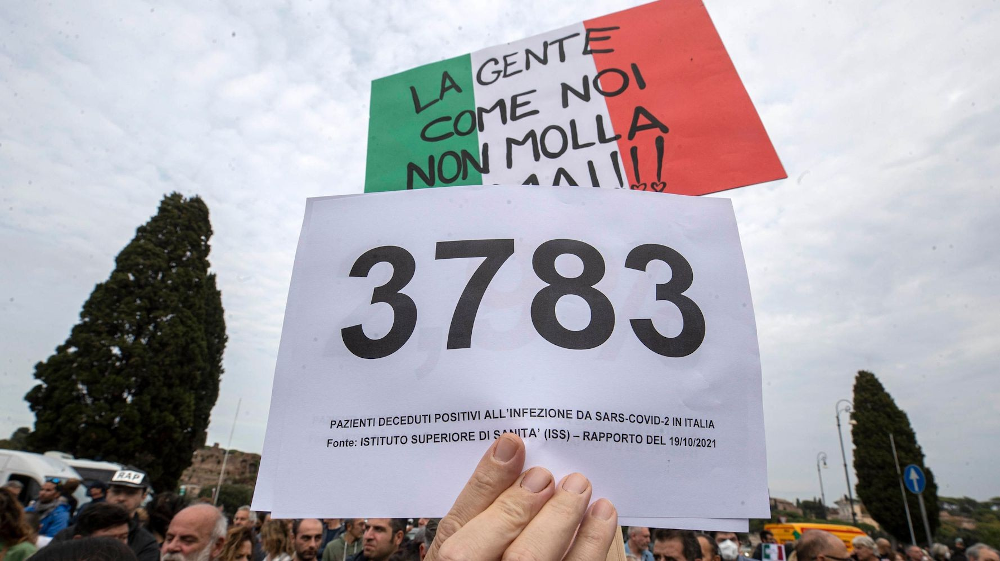

# The goal

The national institute of statistics publishes online the dataset of the daily number of deaths in every italian town from 2011 to now.  

* Site: https://www.istat.it/it/archivio/240401
* Link: [csv](https://www.istat.it/storage/dati_mortalita/Dataset-decessi-comunali-giornalieri-4_3-febbraio-2022.zip)

It is therefore possible to use the 2011-2019 data to calculate average and standard deviation of the total numbers of death in every week of the year. 

\begin{array}{ccc}
 week & 2011-2019 & 2020\\
  1 & x_1 \pm \sigma_1   &y_1\\
  2 & x_2 \pm \sigma_2   &y_2\\
  3 & x_3 \pm \sigma_3   &y_3\\
... & ...    & ...\\
 52 & x_{52} \pm \sigma_52 &y_{52}\\  
\end{array}

Then one can compare this column with the weekly number of deaths in 2020 and 2021. Finally the table can be plotted. 




# The challenge
This analysis has many **challenges**:
* the data is avaiable as an **huge** and zipped *csv* file (500 MB)
* the data has an high level of **granularity**: daily deaths per eday per italian town
* but we need total number of deaths per week
* so we have to **aggregate** data per week and **summing** over all the town
* some entries contains the string *n.a.*, i.e **missing data**
* the date is stored in a **peculiar format**: a string *xxyy*, where *xx* is the month and *yy* the day of the month
* the leap year most be properly handled

These challenges make almost impossible the use of a spreadsheet like excel. 

# Step 0: configuration

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Link ai dati
url="https://www.istat.it/storage/dati_mortalita/Dataset-decessi-comunali-giornalieri-4_3-febbraio-2022.zip"

# Step 1: download the data
Use unix commands to download the data file (*wget*), unzip it and get the name of the file 

In [ ]:
# Download the zip archive using wget ignoring ssl certificate
!wget --no-check-certificate $url

# Get the name of the zipped file
zipfilename=url.split("/")[-1]

# Unzip the file
!unzip $zipfilename

# Get the name of the csv file
filename=!ls *csv
filename=filename[0]

--2022-09-15 10:22:37--  https://www.istat.it/storage/dati_mortalita/Dataset-decessi-comunali-giornalieri-4_3-febbraio-2022.zip
Resolving www.istat.it (www.istat.it)... 193.204.90.6
Connecting to www.istat.it (www.istat.it)|193.204.90.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34479293 (33M) [application/zip]
Saving to: ‘Dataset-decessi-comunali-giornalieri-4_3-febbraio-2022.zip’

Dataset-decessi-com 100%[===================>]  32.88M  1.44MB/s    in 24s     

2022-09-15 10:23:02 (1.36 MB/s) - ‘Dataset-decessi-comunali-giornalieri-4_3-febbraio-2022.zip’ saved [34479293/34479293]

Archive:  Dataset-decessi-comunali-giornalieri-4_3-febbraio-2022.zip
  inflating: comuni_giornaliero_30novembre21.csv  
  inflating: Descrizione e tracciato record dati comunali giornalieri.docx  


# Step 2: the pandas data frame

Create the **pandas dataframe**  
* using the proper encoding: `latin-1`
* considering the field `GE` (the date) as string 
* consider the string `n.d.` as a missing value. 

In [ ]:
df = pd.read_csv(filename, encoding='latin-1', dtype={"GE": str}, na_values=['n.d.'])

Fix the problem with leap years

In [ ]:
# Naively replace "0229" with "0228"
df.loc[df["GE"] == "0229", "GE"] = "0228"

Add a column with the week number. It will be needed to group the data by **week**.

In [ ]:
df["week"]=pd.to_datetime(df["GE"], format='%m%d').dt.isocalendar().week

**NB**: A line for every day (in 10 years) for every town.
Let's show the Pavia record:

In [ ]:
# In the dataframe df, plot only the record regarting the town of Pavia
df[df.NOME_COMUNE == "Pavia"]

,CL_ETA,GE,COD_PROVCOM,FLAG_Q_DEF,REG,PROV,NOME_REGIONE,NOME_PROVINCIA,NOME_COMUNE,FLAG_Q_NEW,...,T_14,T_15,T_16,T_17,T_18,T_19,T_20,T_21,TIPO_COMUNE,week
927734,0,0112,18110,1,3,18,Lombardia,Pavia,Pavia,1,...,0,1,0,0,0,0,0,0.0,1,2
927735,0,0126,18110,1,3,18,Lombardia,Pavia,Pavia,1,...,1,0,0,0,0,0,0,0.0,1,4
927736,0,0128,18110,1,3,18,Lombardia,Pavia,Pavia,1,...,0,0,0,0,0,0,0,0.0,1,4
927737,0,0209,18110,1,3,18,Lombardia,Pavia,Pavia,1,...,0,0,0,1,0,0,0,0.0,1,6
927738,0,0218,18110,1,3,18,Lombardia,Pavia,Pavia,1,...,0,0,0,0,0,0,0,0.0,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
930974,21,1220,18110,1,3,18,Lombardia,Pavia,Pavia,1,...,0,0,0,0,0,0,0,NaN,1,51
930975,21,1223,18110,1,3,18,Lombardia,Pavia,Pavia,1,...,0,0,0,0,0,1,0,NaN,1,51
930976,21,1225,18110,1,3,18,Lombardia,Pavia,Pavia,1,...,0,1,0,0,0,0,0,NaN,1,52
930977,21,1226,18110,1,3,18,Lombardia,Pavia,Pavia,1,...,0,0,0,0,0,0,1,NaN,1,52


# Step 3: data analysis

**Goal**: obtain mean and standard deviation of the number of deaths per week using data records from 2011 to 2019. 

We can use the pandas **groupby** method that can be used to group the data by week and to use the **sum** aggregation functions on the grouped series.

First at all, we create an array with the column names corresponding to 2011-2019. 


In [ ]:
preCovidIndexes=['T_11', 'T_12', 'T_13', 'T_14', 'T_15', 'T_16', 'T_17', 'T_18', 'T_19']

Now we can create a new datafame `dfAgg` with the weekly means and averages.

In [ ]:
dfAgg=pd.DataFrame()
dfAgg["PreAvg"]=df.groupby("week")[preCovidIndexes].sum().mean(axis=1)
dfAgg["PreStd"]=df.groupby("week")[preCovidIndexes].sum().std(axis=1)

And finally, we add the columns corresponding to 2020 and 2021.

In [ ]:
dfAgg["y20"]=df.groupby("week")['T_20'].sum()
dfAgg["y21"]=df.groupby("week")['T_21'].sum()

In [ ]:
dfAgg

,PreAvg,PreStd,y20,y21
week,,,,
1,16653.666667,1679.484668,16195,16821.0
2,14689.222222,1973.580932,14010,16788.0
3,14429.333333,1766.971915,13913,17110.0
4,14241.555556,1310.865660,14181,16588.0
5,14322.555556,1217.056399,13788,16097.0
6,14142.666667,1084.708486,13453,14883.0
7,14137.000000,1111.414977,13540,14503.0
8,13808.555556,1102.483459,13516,14582.0
9,14062.222222,1099.540333,15618,14668.0


# Step 5: the plot
Let's plot the weekly deaths record in 2020 in comparison with the 2011-2019 average. 

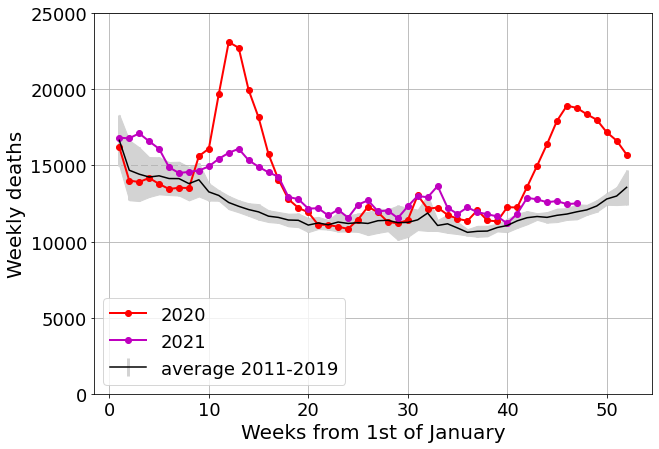

In [ ]:
cut=47  # Need to fix missing data

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,7))
plt.rcParams.update({'font.size': 18})
ax1 = fig.add_subplot(111)

# Scatteplot of weekly deaths 2011-2019: means and standard deviation.
ax1.errorbar(dfAgg.index, dfAgg["PreAvg"], xerr=None, yerr=dfAgg["PreStd"], 
             color="black", ecolor='lightgray', elinewidth=3, capsize=0,
             label="average 2011-2019")

# Use fill_between to represent the error as a band
ax1.fill_between(dfAgg.index * 1.0, dfAgg["PreAvg"] - dfAgg["PreStd"], 
                 dfAgg["PreAvg"] + dfAgg["PreStd"], color="lightgray")


# Plot of weekly deaths in 2020
ax1.plot(dfAgg.index, dfAgg["y20"], 
         "ro-", linewidth=2.0, label="2020")

# Plot of weekly deaths in 2021 (with a cut to fix an error)
ax1.plot(dfAgg.index.to_numpy()[:cut], dfAgg["y21"].head(cut), 
         "mo-", linewidth=2.0, label="2021")

# Add labels
plt.xlabel("Weeks from 1st of January", fontsize=20)
plt.ylabel("Weekly deaths", fontsize=20)
plt.ylim((0,25000))  
plt.grid()
plt.legend()
plt.show()